## CIS508
Transformations in Regressions
Author: SKLearn Documentation

%matplotlib inline


# Effect of transforming the targets in regression model

In this example, we give an overview of
:class:`~sklearn.compose.TransformedTargetRegressor`. We use two examples
to illustrate the benefit of transforming the targets before learning a linear
regression model. The first example uses synthetic data while the second
example is based on the Ames housing data set.   
   
https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html#sphx-glr-auto-examples-compose-plot-transformed-target-py   
   


In [2]:
# Author: Guillaume Lemaitre <guillaume.lemaitre@inria.fr>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import median_absolute_error, r2_score

## Synthetic example



A synthetic random regression dataset is generated. The targets ``y`` are
modified by:

  1. translating all targets such that all entries are
     non-negative (by adding the absolute value of the lowest ``y``) and
  2. applying an exponential function to obtain non-linear
     targets which cannot be fitted using a simple linear model.

Therefore, a logarithmic (`np.log1p`) and an exponential function
(`np.expm1`) will be used to transform the targets before training a linear
regression model and using it for prediction.



In [3]:
X, y = make_regression(n_samples=10000, noise=100, random_state=0)
y = np.expm1((y + abs(y.min())) / 200)
y_trans = np.log1p(y)

Below we plot the probability density functions of the target
before and after applying the logarithmic functions.



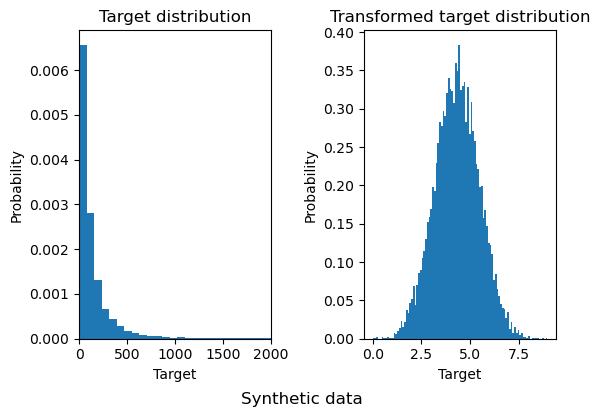

In [4]:
f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y, bins=100, density=True)
ax0.set_xlim([0, 2000])
ax0.set_ylabel("Probability")
ax0.set_xlabel("Target")
ax0.set_title("Target distribution")

ax1.hist(y_trans, bins=100, density=True)
ax1.set_ylabel("Probability")
ax1.set_xlabel("Target")
ax1.set_title("Transformed target distribution")

f.suptitle("Synthetic data", y=0.06, x=0.53)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

At first, a linear model will be applied on the original targets. Due to the
non-linearity, the model trained will not be precise during
prediction. Subsequently, a logarithmic function is used to linearize the
targets, allowing better prediction even with a similar linear model as
reported by the median absolute error (MAE).



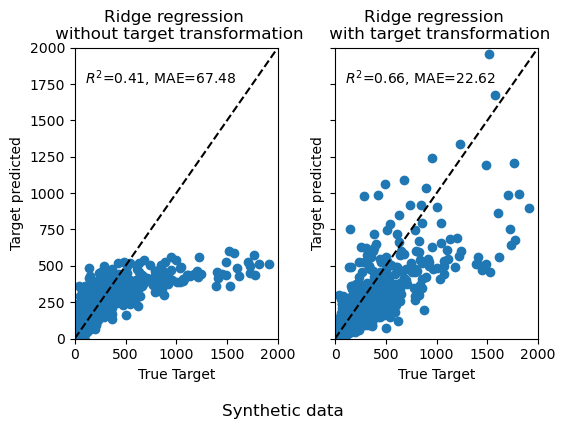

In [5]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)
# Use linear model
regr = RidgeCV()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
# Plot results
ax0.scatter(y_test, y_pred)
ax0.plot([0, 2000], [0, 2000], "--k")
ax0.set_ylabel("Target predicted")
ax0.set_xlabel("True Target")
ax0.set_title("Ridge regression \n without target transformation")
ax0.text(
    100,
    1750,
    r"$R^2$=%.2f, MAE=%.2f"
    % (r2_score(y_test, y_pred), median_absolute_error(y_test, y_pred)),
)
ax0.set_xlim([0, 2000])
ax0.set_ylim([0, 2000])
# Transform targets and use same linear model
regr_trans = TransformedTargetRegressor(
    regressor=RidgeCV(), func=np.log1p, inverse_func=np.expm1
)
regr_trans.fit(X_train, y_train)
y_pred = regr_trans.predict(X_test)

ax1.scatter(y_test, y_pred)
ax1.plot([0, 2000], [0, 2000], "--k")
ax1.set_ylabel("Target predicted")
ax1.set_xlabel("True Target")
ax1.set_title("Ridge regression \n with target transformation")
ax1.text(
    100,
    1750,
    r"$R^2$=%.2f, MAE=%.2f"
    % (r2_score(y_test, y_pred), median_absolute_error(y_test, y_pred)),
)
ax1.set_xlim([0, 2000])
ax1.set_ylim([0, 2000])

f.suptitle("Synthetic data", y=0.035)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

## Real-world data set

 In a similar manner, the Ames housing data set is used to show the impact
 of transforming the targets before learning a model. In this example, the
 target to be predicted is the selling price of each house.



In [6]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import QuantileTransformer, quantile_transform

ames = fetch_openml(name="house_prices", as_frame=True)
# Keep only numeric columns
X = ames.data.select_dtypes(np.number)
# Remove columns with NaN or Inf values
X = X.drop(columns=["LotFrontage", "GarageYrBlt", "MasVnrArea"])
y = ames.target
y_trans = quantile_transform(
    y.to_frame(), n_quantiles=900, output_distribution="normal", copy=True
).squeeze()

A :class:`~sklearn.preprocessing.QuantileTransformer` is used to normalize
the target distribution before applying a
:class:`~sklearn.linear_model.RidgeCV` model.



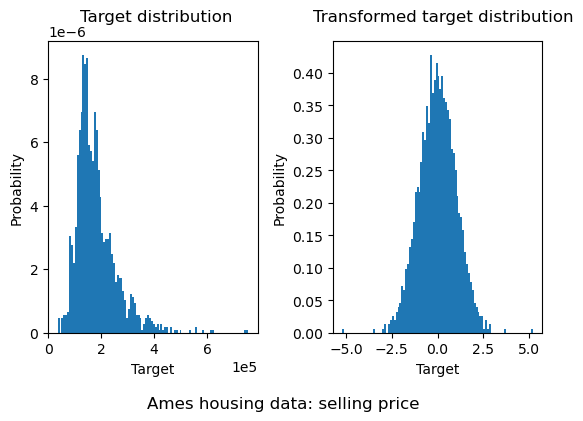

In [7]:
f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y, bins=100, density=True)
ax0.set_ylabel("Probability")
ax0.set_xlabel("Target")
ax0.text(s="Target distribution", x=1.2e5, y=9.8e-6, fontsize=12)
ax0.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

ax1.hist(y_trans, bins=100, density=True)
ax1.set_ylabel("Probability")
ax1.set_xlabel("Target")
ax1.text(s="Transformed target distribution", x=-6.8, y=0.479, fontsize=12)

f.suptitle("Ames housing data: selling price", y=0.04)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

The effect of the transformer is weaker than on the synthetic data. However,
the transformation results in an increase in $R^2$ and large decrease
of the MAE. The residual plot (predicted target - true target vs predicted
target) without target transformation takes on a curved, 'reverse smile'
shape due to residual values that vary depending on the value of predicted
target. With target transformation, the shape is more linear indicating
better model fit.



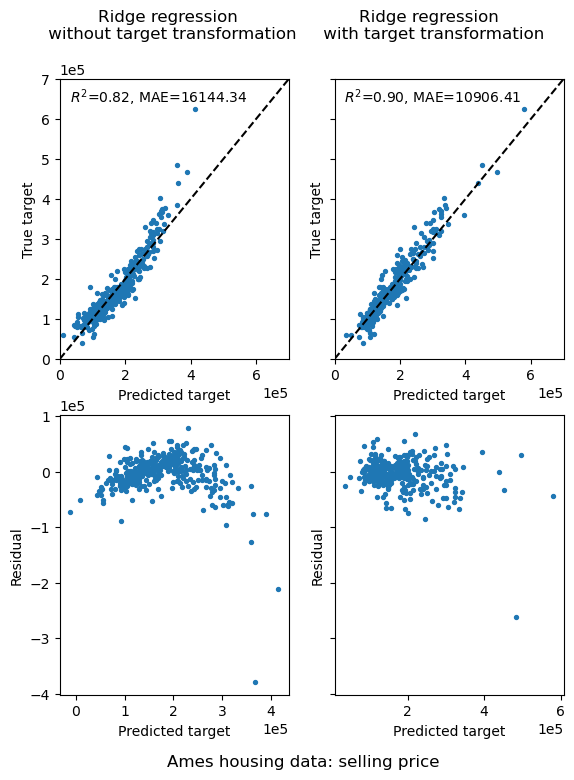

In [8]:
f, (ax0, ax1) = plt.subplots(2, 2, sharey="row", figsize=(6.5, 8))

regr = RidgeCV()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

ax0[0].scatter(y_pred, y_test, s=8)
ax0[0].plot([0, 7e5], [0, 7e5], "--k")
ax0[0].set_ylabel("True target")
ax0[0].set_xlabel("Predicted target")
ax0[0].text(
    s="Ridge regression \n without target transformation",
    x=-5e4,
    y=8e5,
    fontsize=12,
    multialignment="center",
)
ax0[0].text(
    3e4,
    64e4,
    r"$R^2$=%.2f, MAE=%.2f"
    % (r2_score(y_test, y_pred), median_absolute_error(y_test, y_pred)),
)
ax0[0].set_xlim([0, 7e5])
ax0[0].set_ylim([0, 7e5])
ax0[0].ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

ax1[0].scatter(y_pred, (y_pred - y_test), s=8)
ax1[0].set_ylabel("Residual")
ax1[0].set_xlabel("Predicted target")
ax1[0].ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

regr_trans = TransformedTargetRegressor(
    regressor=RidgeCV(),
    transformer=QuantileTransformer(n_quantiles=900, output_distribution="normal"),
)
regr_trans.fit(X_train, y_train)
y_pred = regr_trans.predict(X_test)

ax0[1].scatter(y_pred, y_test, s=8)
ax0[1].plot([0, 7e5], [0, 7e5], "--k")
ax0[1].set_ylabel("True target")
ax0[1].set_xlabel("Predicted target")
ax0[1].text(
    s="Ridge regression \n with target transformation",
    x=-5e4,
    y=8e5,
    fontsize=12,
    multialignment="center",
)
ax0[1].text(
    3e4,
    64e4,
    r"$R^2$=%.2f, MAE=%.2f"
    % (r2_score(y_test, y_pred), median_absolute_error(y_test, y_pred)),
)
ax0[1].set_xlim([0, 7e5])
ax0[1].set_ylim([0, 7e5])
ax0[1].ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

ax1[1].scatter(y_pred, (y_pred - y_test), s=8)
ax1[1].set_ylabel("Residual")
ax1[1].set_xlabel("Predicted target")
ax1[1].ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

f.suptitle("Ames housing data: selling price", y=0.035)

plt.show()